# Contexte:

Dans ce notebook, sur la base de données anonymisée d'OLIST nettoyées( Solution de vente sur les marketplaces en ligne) comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, les variables Recency, Frequency, Monetary...
On va effectuer une segmentation de clients grace à, des algorithmes d'apprentissage non-supervisé.

<h1>Sommaire<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-des-librairies-et-préparation-de-l'environnement-du-travail" data-toc-modified-id="Import-des-librairies-et-préparation-de-l'environnement-du-travail-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import des librairies et préparation de l'environnement du travail</a></span></li><li><span><a href="#Import-des-données" data-toc-modified-id="Import-des-données-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import des données</a></span></li><li><span><a href="#Recherche-du-nombre-de-clusters-optimal" data-toc-modified-id="Recherche-du-nombre-de-clusters-optimal-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Recherche du nombre de clusters optimal</a></span><ul class="toc-item"><li><span><a href="#Elbow-Method-avec-Elbow-visualizer" data-toc-modified-id="Elbow-Method-avec-Elbow-visualizer-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Elbow Method avec Elbow visualizer</a></span></li></ul></li><li><span><a href="#Clustering-avec-Kmeans" data-toc-modified-id="Clustering-avec-Kmeans-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering avec Kmeans</a></span><ul class="toc-item"><li><span><a href="#Jeu-de-données-complet" data-toc-modified-id="Jeu-de-données-complet-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Jeu de données complet</a></span></li><li><span><a href="#Données-projetées-sur-les-axes-principaux" data-toc-modified-id="Données-projetées-sur-les-axes-principaux-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Données projetées sur les axes principaux</a></span></li><li><span><a href="#Données-RFM:-Recency,-Frequency,-Monetary" data-toc-modified-id="Données-RFM:-Recency,-Frequency,-Monetary-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Données RFM: Recency, Frequency, Monetary</a></span></li><li><span><a href="#Données-RFM-et-satisfaction" data-toc-modified-id="Données-RFM-et-satisfaction-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Données RFM et satisfaction</a></span></li><li><span><a href="#Comparaison-des-performances" data-toc-modified-id="Comparaison-des-performances-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Comparaison des performances</a></span></li></ul></li><li><span><a href="#Clustering-Hiérarchique:-Agglomerative-clustering" data-toc-modified-id="Clustering-Hiérarchique:-Agglomerative-clustering-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Clustering Hiérarchique: Agglomerative clustering</a></span></li><li><span><a href="#Modélisation" data-toc-modified-id="Modélisation-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Modélisation</a></span></li><li><span><a href="#Stabilité-temporaire-des-clusters" data-toc-modified-id="Stabilité-temporaire-des-clusters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Stabilité temporaire des clusters</a></span></li></ul></div>

## Import des librairies et préparation de l'environnement du travail

On va importer les librairies nécessaires pour notre travail 

In [1]:
%load_ext pycodestyle_magic 

In [2]:
%pycodestyle_on

In [3]:
# pip uninstall -y scikit-learn

In [4]:
# pip install scikit-learn==0.22.2.post1

In [5]:
# %%flake8  # checking PEP8 compliance
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import sklearn
import pygal
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from urllib import request
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from adjustText import adjust_text
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import adjusted_rand_score
import re
import os
import zipfile
from IPython.core.interactiveshell import InteractiveShell
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from sklearn.model_selection import cross_validate
from scipy.spatial import distance
# %% inline pylab
InteractiveShell.ast_node_interactivity = "all"

## Import des données

On va importer nos deux jeux de données nettoyées et résultats du travail effectué dans le notebook 'POLIST_01_notebookanalyse'.

In [6]:
path = r"\Users\Utilisateur\Downloads\data_pca.csv"
path2 = r"\Users\Utilisateur\Downloads\data_olist.csv"
data_pca = pd.read_csv(path)
data = pd.read_csv(path2)

In [7]:
data.drop(columns='date', inplace=True)

In [8]:
data.head()

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,598.0,1.0,0.0,1.0,355,2,8,13.29,13.29,72.19,72.19,1,1,1,7,5.0
1,598.0,0.0,0.0,1.0,431,2,11,17.96,17.96,73.86,73.86,1,1,1,15,5.0
2,598.0,1.0,0.0,1.0,107,4,10,18.33,18.33,83.23,83.23,1,1,1,17,4.0
3,598.0,1.0,0.0,1.0,397,1,18,16.17,16.17,75.07,75.07,1,1,1,8,5.0
4,598.0,1.0,0.0,1.0,388,3,21,13.29,13.29,72.19,72.19,1,1,1,13,5.0


On sait que l'algorithme kmeans requiert la normalisation de ses données pour avoir la meme contribution des features sur le clustering des individus

In [9]:
# normalisation des données
data_pca_scaled = sklearn.preprocessing.StandardScaler(
                  ).fit_transform(data_pca)

In [10]:
# normalisation des données
data_scaled = sklearn.preprocessing.StandardScaler().fit_transform(data)

Pour le clustering hiérarchique on va utiliser un échantillon de notre jeu de données, en raison de complexité et besoin en mémoire de l'algorithme.


In [11]:
# normalisation des données pour clustering hiérarchique
data_cah_int = data.sample(frac=0.3, random_state=0)
data_cah = sklearn.preprocessing.StandardScaler(
           ).fit_transform(data_cah_int)

In [12]:
data_cah = sklearn.preprocessing.StandardScaler(
           ).fit_transform(data_cah_int)

In [13]:
data_cah

array([[-0.56343298, -1.56585217, -0.54959586, ..., -0.2077059 ,
        -0.73147049,  0.66647098],
       [ 0.64463563,  0.23667802, -0.54959586, ..., -0.2077059 ,
        -1.1438081 ,  0.66647098],
       [-0.14129973,  0.23667802, -0.54959586, ..., -0.2077059 ,
         1.43330199, -2.45219886],
       ...,
       [ 0.38521556,  0.23667802, -0.54959586, ..., -0.2077059 ,
         3.80424328, -2.45219886],
       [-0.77066203,  3.8417384 , -0.54959586, ..., -0.2077059 ,
        -0.11296406, -0.11319648],
       [ 0.23017753,  3.8417384 , -0.54959586, ..., -0.2077059 ,
        -0.62838608,  0.66647098]])

In [14]:
data_scaled

array([[-0.301431  ,  0.23589407, -0.54363208, ..., -0.20506358,
        -0.53325044,  0.66661424],
       [-0.301431  , -1.5645703 , -0.54363208, ..., -0.20506358,
         0.30467238,  0.66661424],
       [-0.301431  ,  0.23589407, -0.54363208, ..., -0.20506358,
         0.51415308, -0.11230471],
       ...,
       [ 0.7917559 , -1.5645703 , -0.54363208, ..., -0.20506358,
        -0.63799079, -0.11230471],
       [ 1.7629629 , -1.5645703 , -0.54363208, ..., -0.20506358,
         0.82837414, -2.44906157],
       [-0.85111255,  0.23589407, -0.54363208, ..., -0.20506358,
        -0.53325044,  0.66661424]])

In [15]:
data_plot_cah = data.sample(frac=0.3, random_state=0).iloc[:, :2]

In [16]:
data_plot = data_pca.iloc[:, :2]

In [17]:
data_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95124 entries, 0 to 95123
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      95124 non-null  float64
 1   F2      95124 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


## Recherche du nombre de clusters optimal 

### Elbow Method avec Elbow visualizer

On va utiliser la méthode du coude/"Elbow", pour trouver le meilleur nombre de cluster. L'analyse va se baser sur 3 métriques, à savoir:
- Distortion:  la somme des distances au carré de chaque point à son centre attribué
- Silhouette score:  La valeur de silhouette est une mesure de la similitude d'un objet avec son propre cluster (cohésion) par rapport à d'autres clusters.
- Calinski_harabasz: calcule le rapport de dispersion entre et au sein des clusters. 

In [18]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [19]:
import yellowbrick
yellowbrick.__version__

'1.3.post1'

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=9,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=0,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)

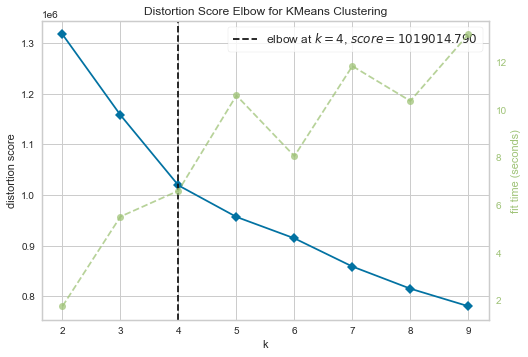

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Instantier le model clustering  et visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(
    model, k=(2, 10), timings=True)

visualizer.fit(data_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=9,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=0,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='silhouette', timings=True)

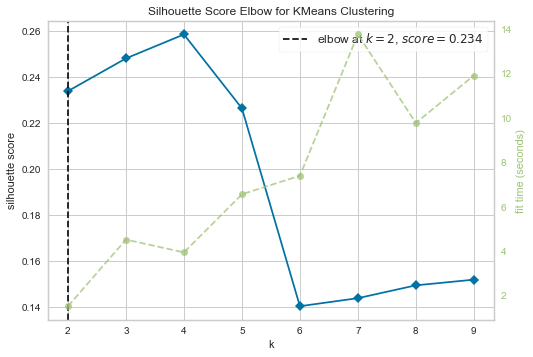

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(
    model, k=(2, 10), metric='silhouette', timings=True
)
visualizer.fit(data_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\base.py:193: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


KElbowVisualizer(ax=<AxesSubplot:>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=9,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto', random_state=0,
                                  tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='calinski_harabasz',
                 timings=True)

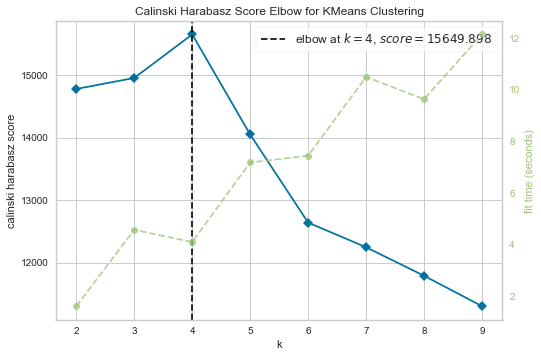

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [22]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(
    model, k=(2, 10), metric='calinski_harabasz', timings=True
)
visualizer.fit(data_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

On trouve que  le meilleur clustering va etre obtenu pour une séparation en 4 clusters.

## Clustering avec Kmeans

On va appliquer l'algorithme KMeans sur différents scénarios et on va évaluer leurs performances en utilisant l'inertie, le coefficient de silhouette et l'indice de davies_bouldin.

### Jeu de données complet

On va créer un méthode qui applique l'algorithme KMEANS pour une plage entre 2 et 10 clusters et on va calculer nos 3 métriques pour pouvoir consolider les résultats obtenus avant et comparer les performances des différents scénarios.

In [23]:
n = 10

In [24]:
def clustering_fct(data, n):
    inertia = []
    silhouette_scores = []
    davies_bouldin = []
    for i in range(2, n+1):
        model = KMeans(n_clusters=i, random_state=0).fit(data)
        centroids = model.cluster_centers_
        labels = model.labels_
        u = model.inertia_
        inertia.append(u)
        silhouette_scores.append(silhouette_score(data, model.labels_))
        index_db_val = davies_bouldin_score(data, labels)
        davies_bouldin.append(index_db_val)
        data_plot['labels'] = model.labels_
        plt.figure(figsize=(8, 8))
        plt.scatter(x=data_plot['F1'], y=data_plot['F2'],
                    c=data_plot['labels'], cmap="nipy_spectral")
        plt.title(str(i)+' Clusters')
        plt.legend()
        plt.show()
    return inertia, silhouette_scores, davies_bouldin

In [25]:
def plot_silhouete_score(silhouette_scores, n):
    plt.plot(range(2, n+1), silhouette_scores, color='black', marker='D')
    plt.grid()
    plt.xticks(list(range(2, n+1)))
    plt.title('silhouette scores')
    plt.xlabel('nombre de clusters')
    plt.ylabel('score silhouette')

In [26]:
def plot_inertia(inertia, n):
    plt.plot(range(2, n+1), inertia, color='black', marker='D')
    plt.grid()
    plt.xticks(list(range(2, n+1)))
    plt.title('L\'inertie')
    plt.xlabel('nombre de clusters')
    plt.ylabel('l\'inertie')

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


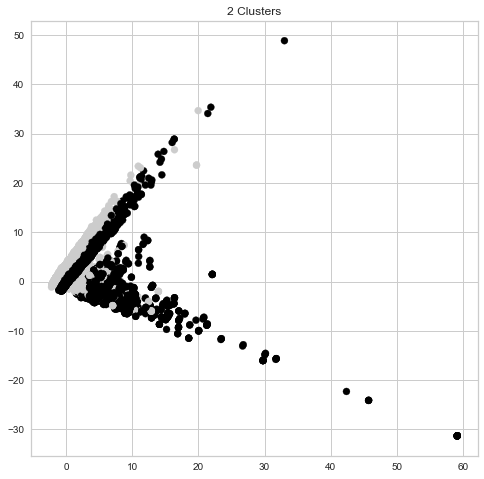

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


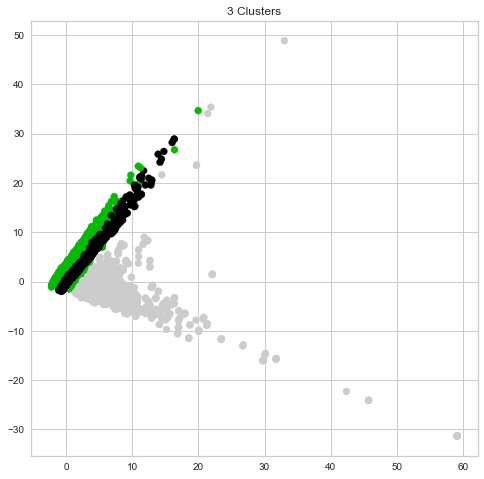

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


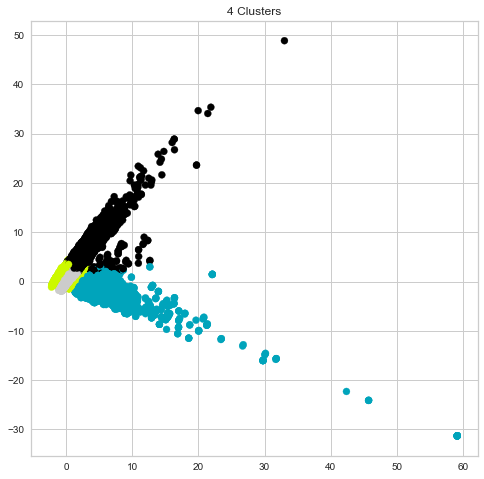

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


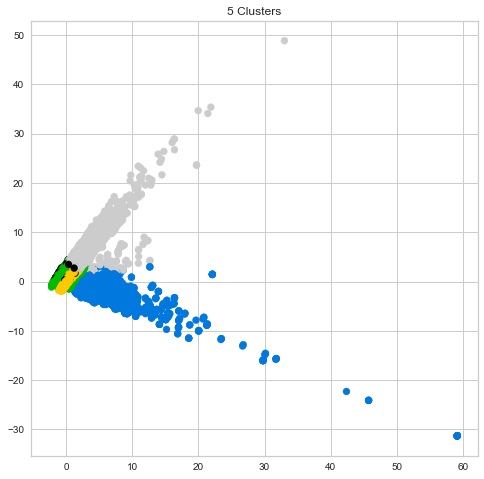

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


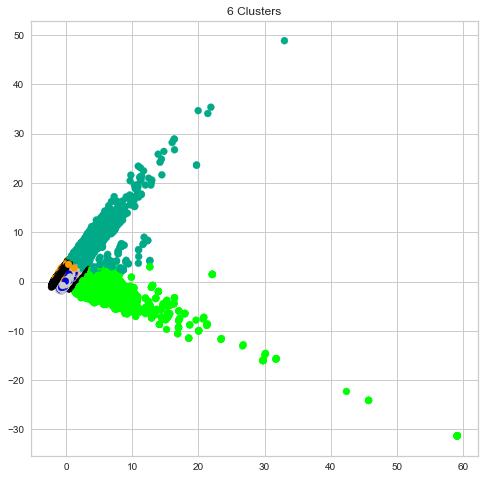

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


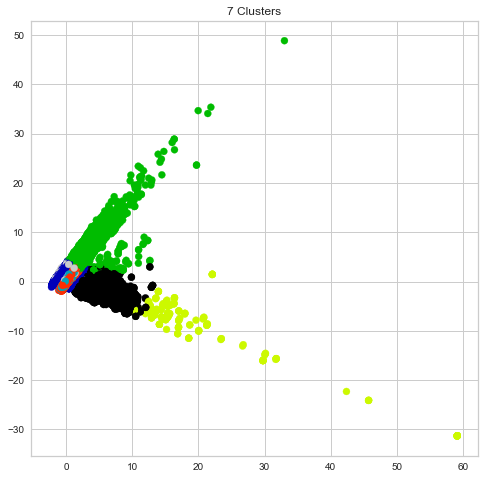

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


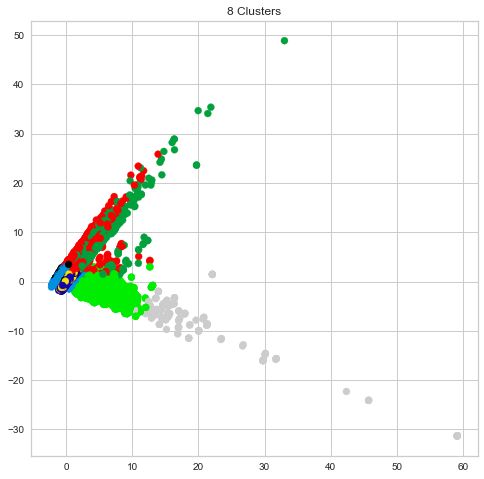

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


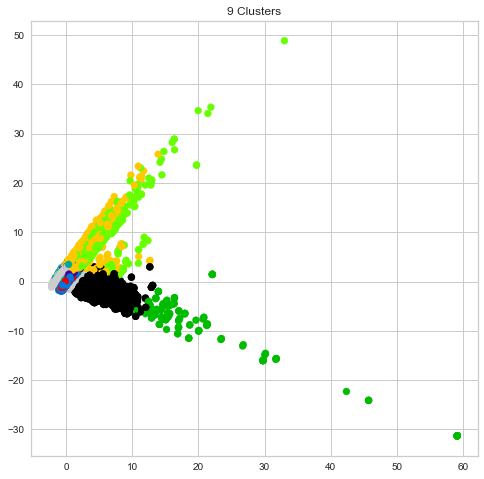

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


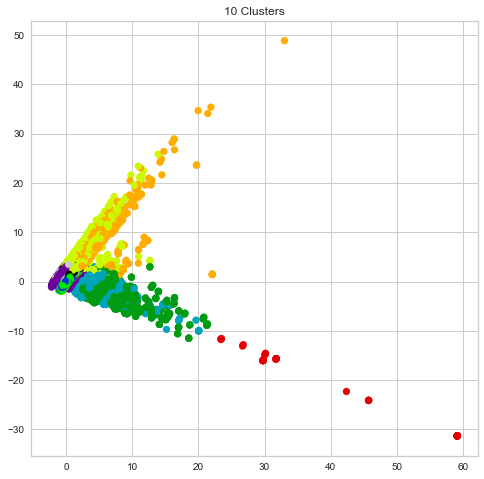

In [27]:
inertia, silhouette_scores, davies_bouldin = clustering_fct(data_scaled, n)

In [28]:
df = pd.DataFrame(list(zip(inertia, silhouette_scores, davies_bouldin)),
                  columns=['inertia', 'silhouette_score', 'davies_bouldin'],
                  index=[2, 3, 4, 5, 6, 7, 8, 9, 10])

In [29]:
df

,inertia,silhouette_score,davies_bouldin
2,1.317334e+06,0.233952,1.733698
3,1.157939e+06,0.248176,1.528162
4,1.019015e+06,0.258617,1.382916
5,9.567480e+05,0.226457,1.581048
6,9.144451e+05,0.140352,1.756997
7,8.587318e+05,0.143849,1.643997
8,8.149815e+05,0.149433,1.587552
9,7.803029e+05,0.151906,1.535993
10,7.470375e+05,0.156167,1.542568


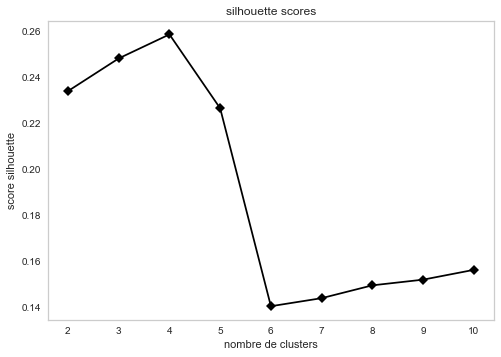

In [30]:
plot_silhouete_score(silhouette_scores, n)

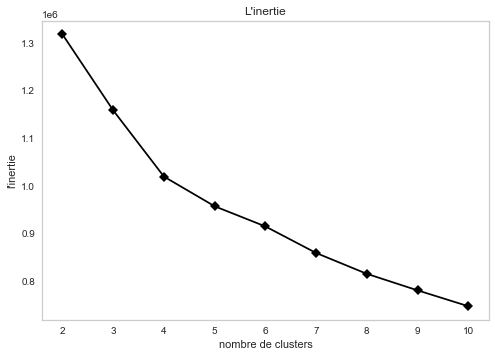

In [31]:
plot_inertia(inertia, n)

### Données projetées sur les axes principaux

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


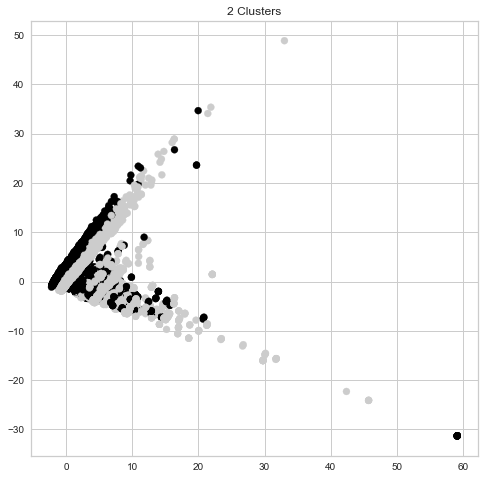

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


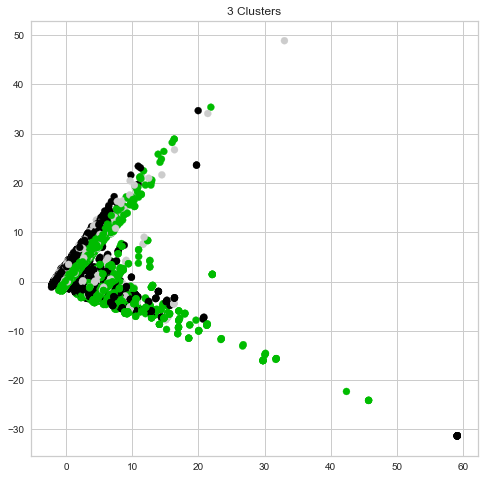

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


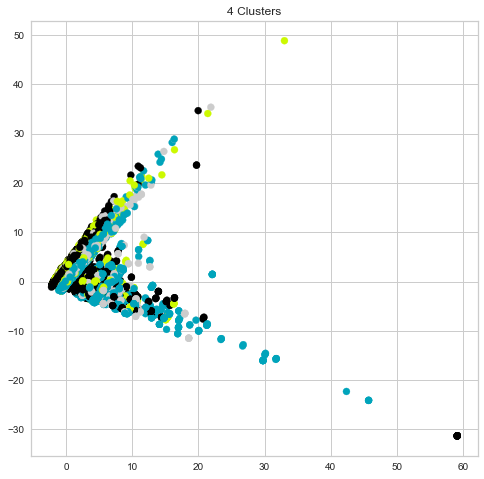

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


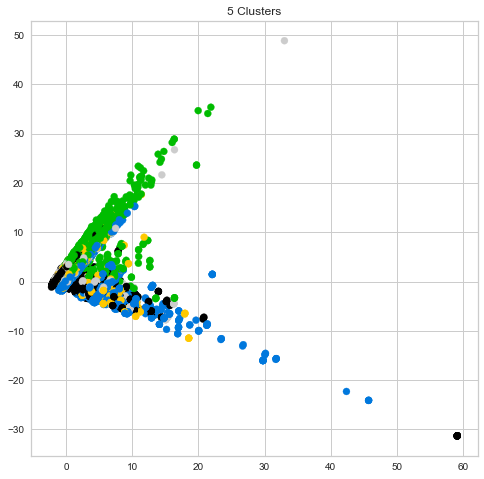

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


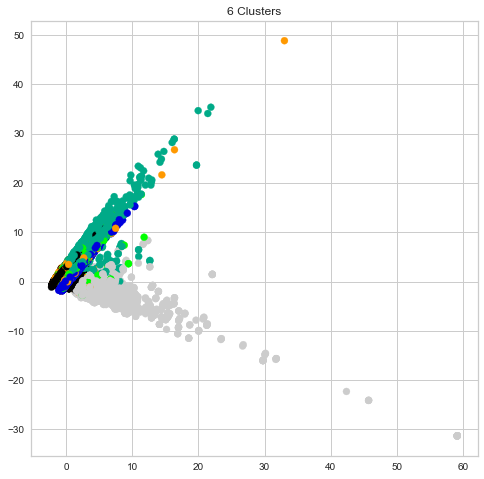

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


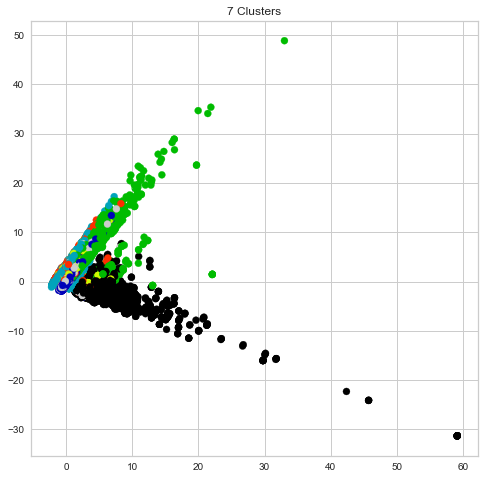

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


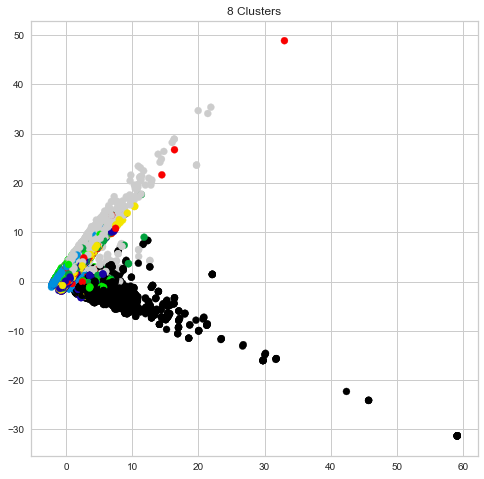

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


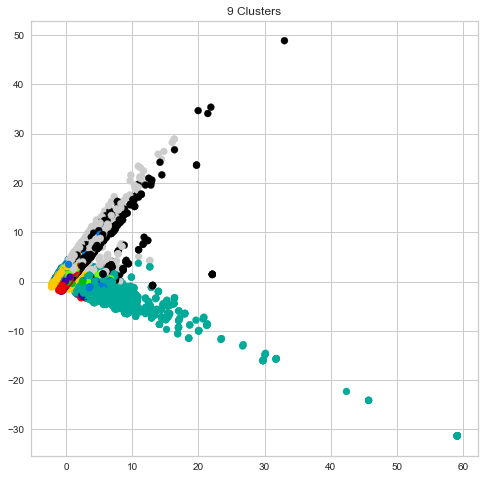

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


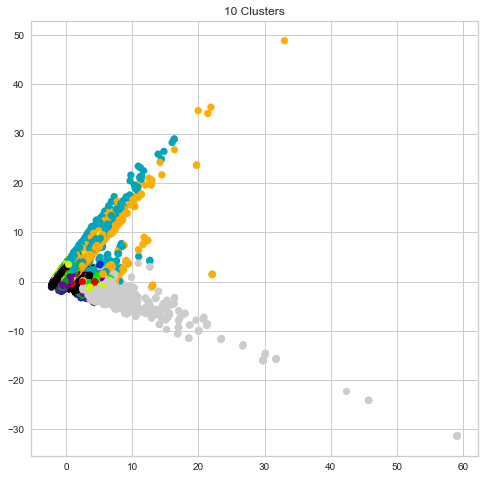

In [32]:
inertia, silhouette_scores, davies_bouldin = clustering_fct(data_pca_scaled, n)

In [33]:
df['inertia_pca'] = inertia
df['silhouette_score_pca'] = silhouette_scores
df['davies_bouldin_pca'] = davies_bouldin

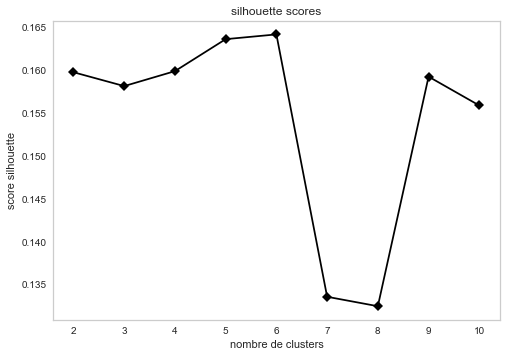

In [34]:
plot_silhouete_score(silhouette_scores, n)

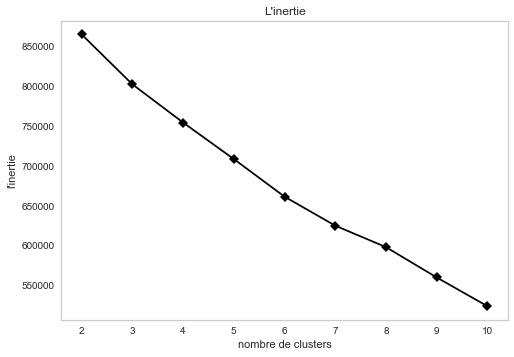

In [35]:
plot_inertia(inertia, n)

In [36]:
data.columns

Index(['Taille_description_moy', 'paiement_type', 'Nombre_achat_weekend',
       'Nombre_achat_semaine', 'Recency', 'Jour_achat_frequent',
       'Heure_achat_freq', 'Frais_Port_max', 'Frais_Port_moy',
       'Dépense_moyenne', 'Monetary', 'Frequency',
       'Nombre_produit_par_catégorie', 'Nombre_de_produit_achetés',
       'Temps_livraison', 'review_score_moy'],
      dtype='object')

### Données RFM: Recency, Frequency, Monetary

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


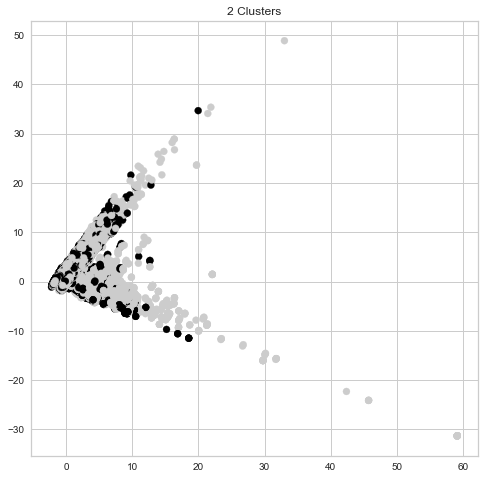

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


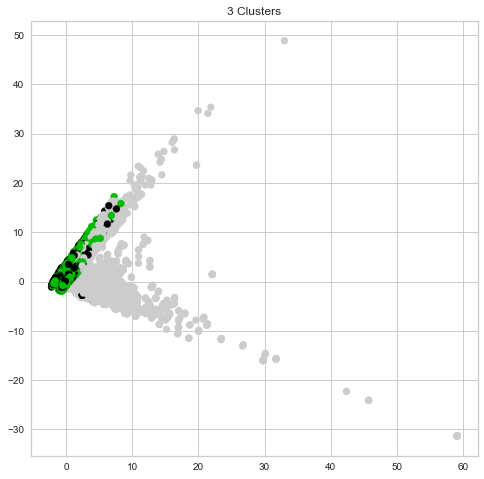

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


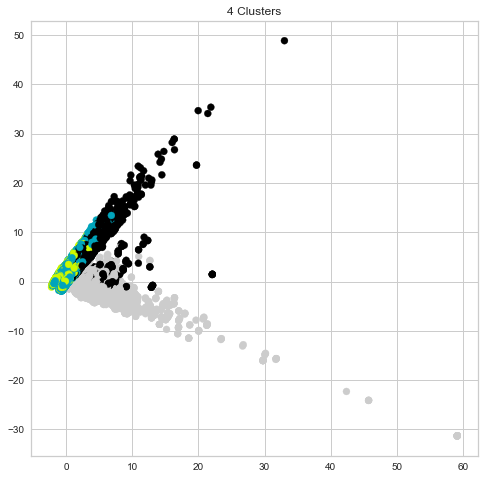

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


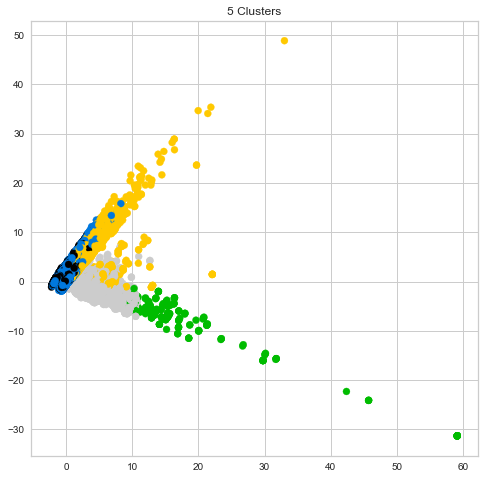

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


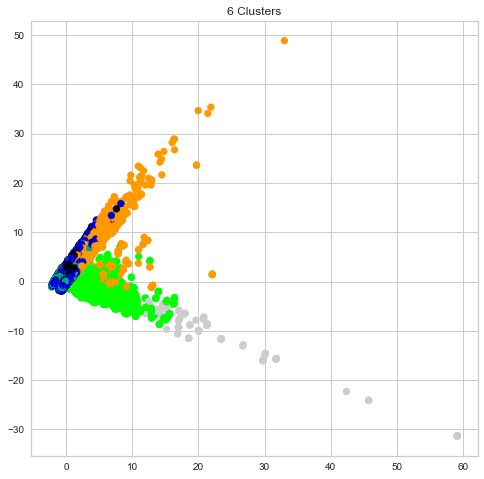

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


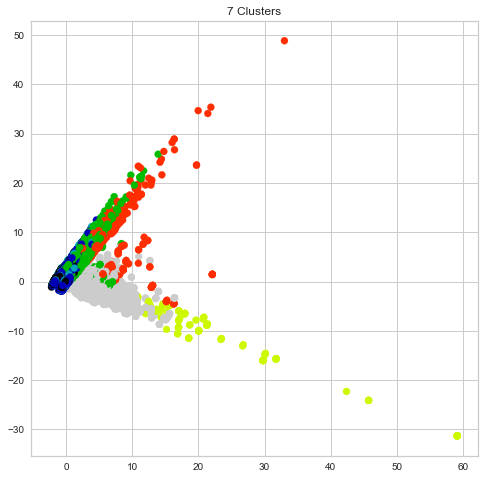

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


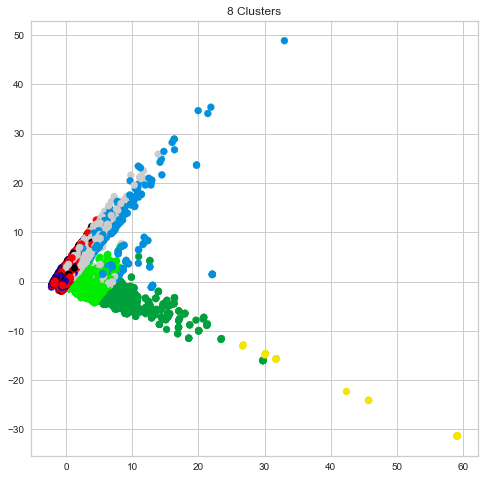

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


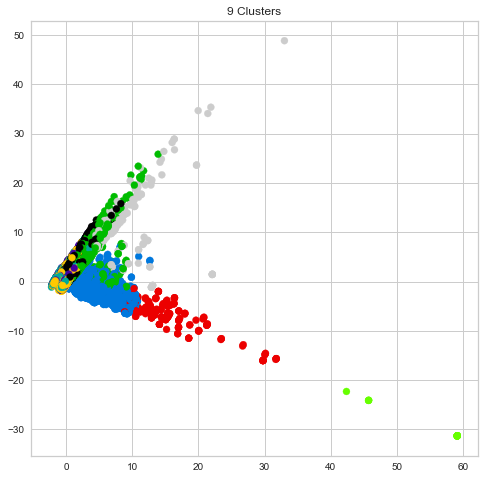

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


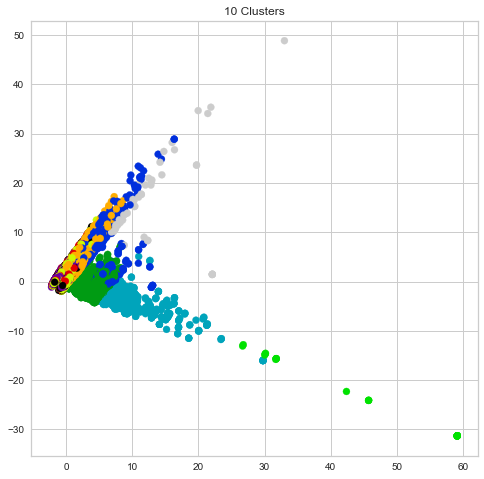

In [37]:
data_rfm_scaled = sklearn.preprocessing.StandardScaler().fit_transform(
                  data[['Recency', 'Monetary', 'Frequency']])
inertia, silhouette_scores, davies_bouldin = clustering_fct(
                                             data_rfm_scaled, n)

In [38]:
df['inertia_rfm'] = inertia
df['silhouette_score_rfm'] = silhouette_scores
df['davies_bouldin_rfm'] = davies_bouldin

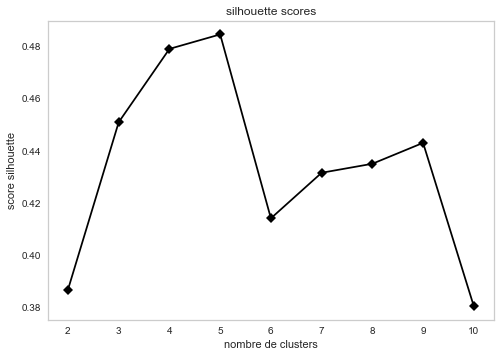

In [39]:
plot_silhouete_score(silhouette_scores, n)

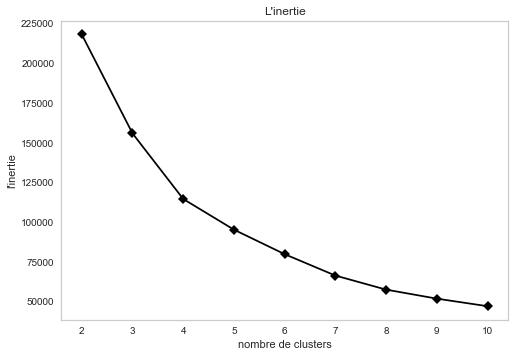

In [40]:
plot_inertia(inertia, n)

### Données RFM et satisfaction

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


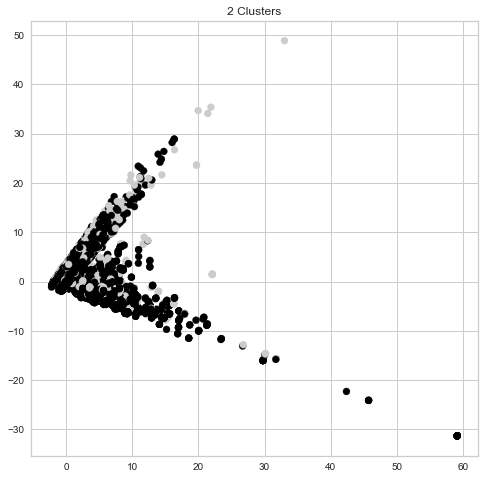

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


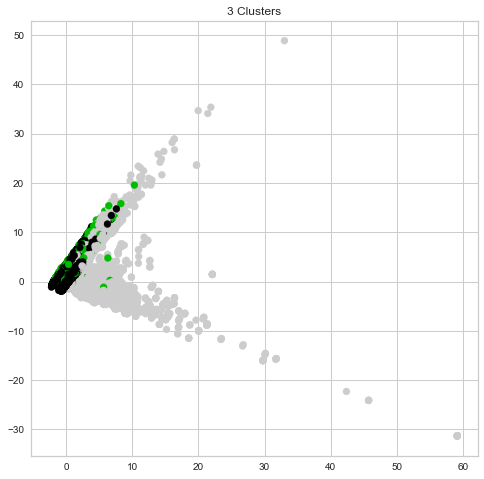

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


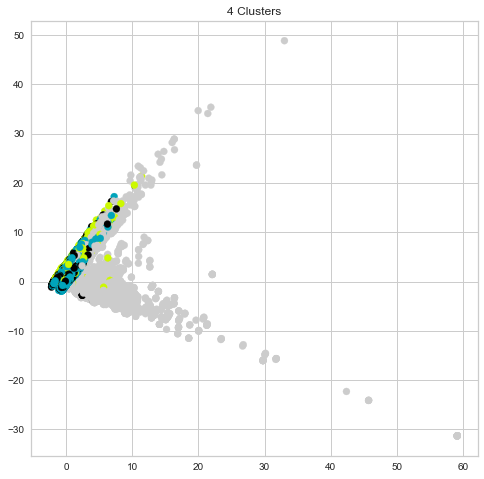

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


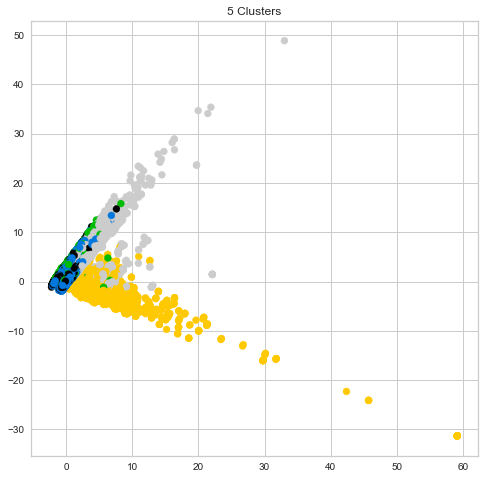

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


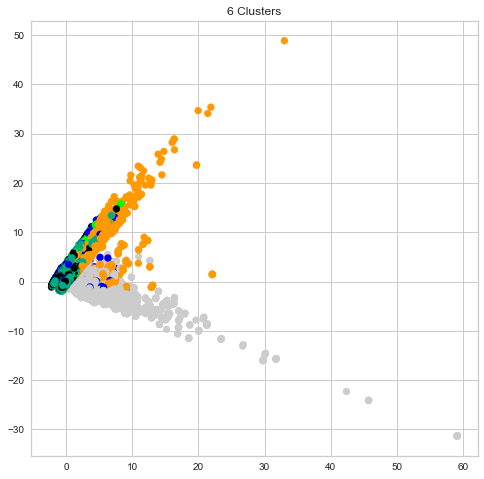

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


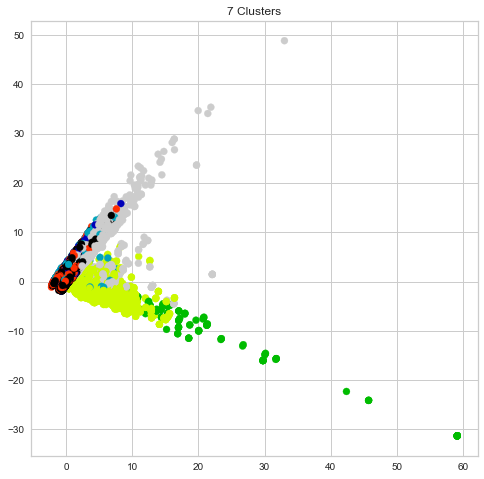

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


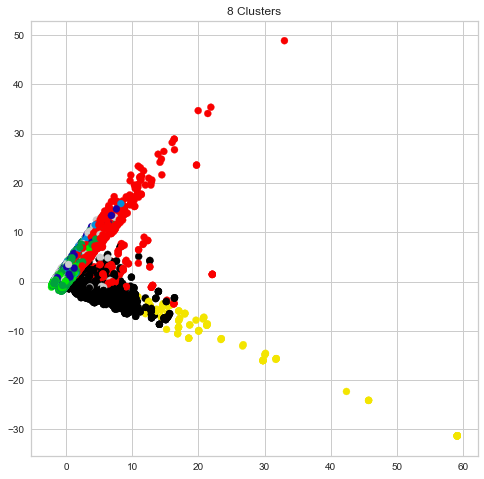

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


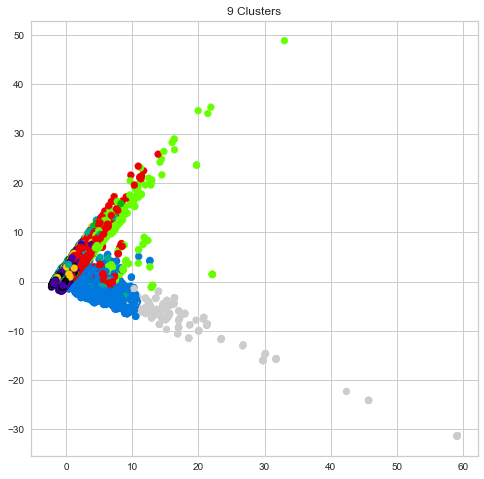

<ipython-input-24-4627f6fa1e29>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


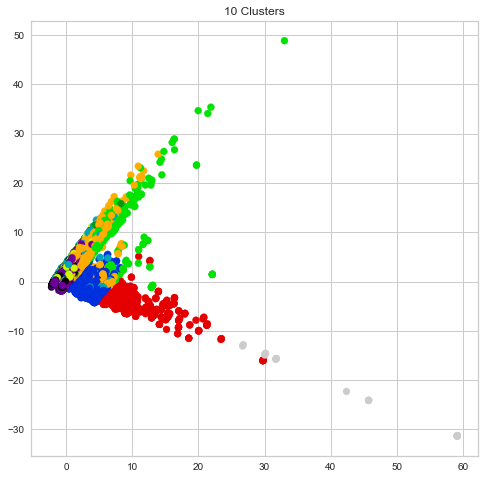

In [41]:
data_rfmr_scaled = sklearn.preprocessing.StandardScaler().fit_transform(
                   data[['Recency', 'Monetary', 'Frequency',
                         'review_score_moy', 'Temps_livraison']])
inertia, silhouette_scores, davies_bouldin = clustering_fct(data_rfmr_scaled,
                                                            n)

In [42]:
df['inertia_rfmr'] = inertia
df['silhouette_score_rfmr'] = silhouette_scores
df['davies_bouldin_rfmr'] = davies_bouldin

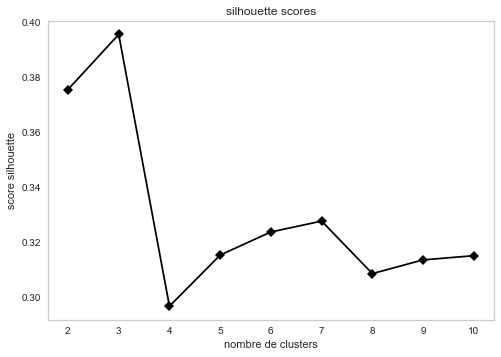

In [43]:
plot_silhouete_score(silhouette_scores, n)

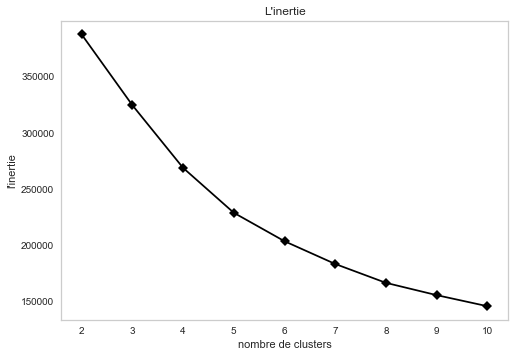

In [44]:
plot_inertia(inertia, n)

### Comparaison des performances

([<matplotlib.axis.XTick at 0x269dda13fd0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'homogénité scores')

Text(0.5, 0, 'nombre de clusters')

Text(0, 0.5, 'score inertie')

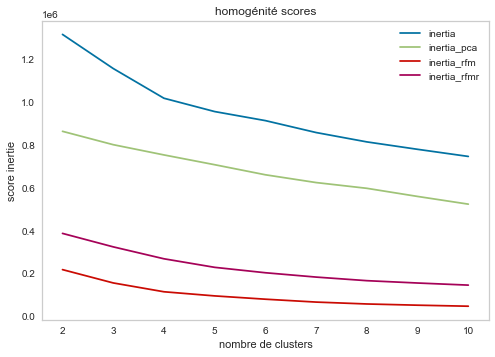

In [45]:
plt.plot(df[['inertia', 'inertia_pca', 'inertia_rfm', 'inertia_rfmr']],
         label=['inertia', 'inertia_pca', 'inertia_rfm', 'inertia_rfmr'])
plt.legend()
plt.grid()
plt.xticks(list(range(2, n+1)))
plt.title('homogénité scores')
plt.xlabel('nombre de clusters')
plt.ylabel('score inertie')

([<matplotlib.axis.XTick at 0x269ddb4a160>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'silhouette scores')

Text(0.5, 0, 'nombre de clusters')

Text(0, 0.5, 'score silhouette')

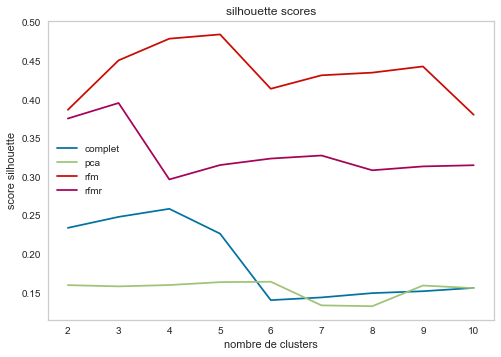

In [46]:
plt.plot(df[['silhouette_score', 'silhouette_score_pca',
             'silhouette_score_rfm', 'silhouette_score_rfmr']],
         label=['complet', 'pca', 'rfm', 'rfmr'])
plt.legend()
plt.grid()
plt.xticks(list(range(2, n+1)))
plt.title('silhouette scores')
plt.xlabel('nombre de clusters')
plt.ylabel('score silhouette')

([<matplotlib.axis.XTick at 0x269dd8a6070>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 1.0, 'indice davies bouldin')

Text(0.5, 0, 'nombre de clusters')

Text(0, 0.5, 'indice davies bouldin')

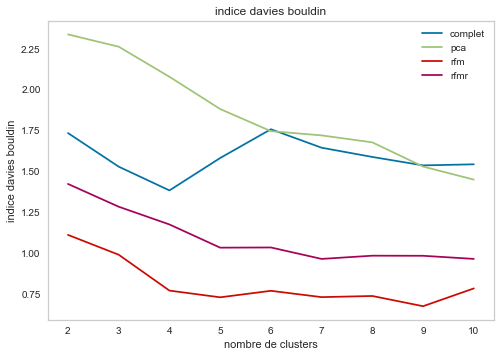

In [47]:
plt.plot(df[['davies_bouldin', 'davies_bouldin_pca',
             'davies_bouldin_rfm', 'davies_bouldin_rfmr']],
         label=['complet', 'pca', 'rfm', 'rfmr'])
plt.legend()
plt.grid()
plt.xticks(list(range(2, n+1)))
plt.title('indice davies bouldin')
plt.xlabel('nombre de clusters')
plt.ylabel('indice davies bouldin')

## Clustering Hiérarchique: Agglomerative clustering

on va utiliser le clustering agglomeratif, il commence par considérer que chaque point est un cluster à lui tout seul. Ensuite, on trouve les deux clusters les plus proches, et on les agglomère en un seul cluster. On répète cette étape jusqu'à ce que tous les points appartiennent à un seul cluster, constitué de l'agglomération de tous les clusters initiaux.

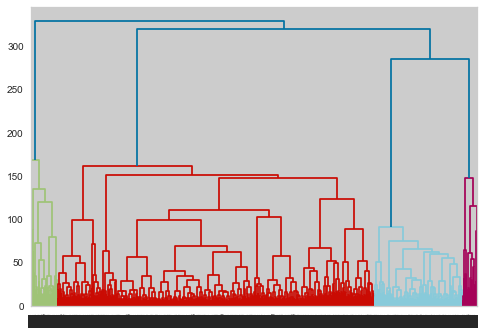

In [48]:
dendrogram = sch.dendrogram(sch.linkage(data_cah, method='ward'))

In [49]:
k = 4
model_CAH = AgglomerativeClustering(n_clusters=k, affinity='euclidean',
                                    linkage='ward').fit_predict(data_cah)

In [50]:
len(model_CAH)

28537

In [51]:
model_CAH

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Clustering agglomératif avec 4 Clusters')

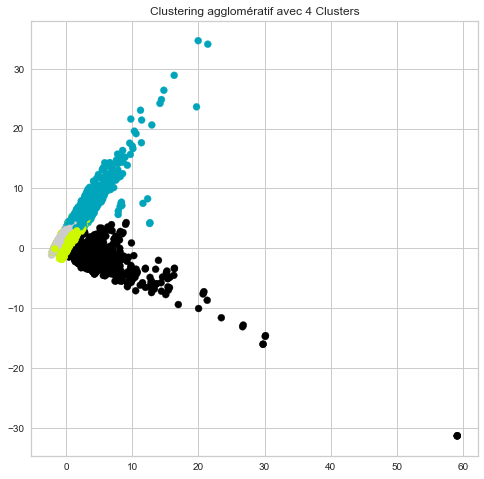

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(x=data_pca.sample(frac=0.3,
                              random_state=0).iloc[:, :2]['F1'],
            y=data_pca.sample(frac=0.3,
                              random_state=0).iloc[:, :2]['F2'],
            c=model_CAH, cmap="nipy_spectral")
plt.title('Clustering agglomératif avec ' + str(k) + ' Clusters')
plt.show()

In [53]:
data_scal_h = np.abs(data_cah_int - data_cah_int.mean()) / data_cah_int.std()

In [54]:
data_scal_h

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
88616,0.563423,1.565825,0.549586,0.332464,0.201776,1.387006,0.047190,0.774135,0.777115,0.636570,0.641429,0.207702,0.153205,0.207702,0.731458,0.666459
20095,0.644624,0.236674,0.549586,0.332464,1.139722,0.376307,0.790276,0.685757,0.686563,0.366406,0.388358,0.207702,0.153205,0.207702,1.143788,0.666459
70361,0.141297,0.236674,0.549586,0.332464,0.210489,1.387006,0.138582,0.145798,0.133330,0.619761,0.535415,0.207702,0.153205,0.207702,1.433277,2.452156
37841,0.893449,1.565825,0.549586,0.332464,0.888886,0.881656,1.253211,0.315291,0.306991,0.262283,0.290823,0.207702,0.153205,0.207702,0.917864,0.113194
76190,0.024483,0.236674,1.650378,1.558987,1.480005,1.139741,0.510125,1.377831,1.427753,4.013287,3.714237,0.207702,0.153205,0.207702,0.628375,0.892848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41045,0.974804,1.565825,0.549586,0.332464,0.275928,0.634392,1.253211,0.331030,0.323117,0.476116,0.491127,0.207702,0.153205,0.207702,0.711699,2.452156
8115,0.030777,3.841671,1.650378,1.558987,0.655474,1.139741,0.047190,0.323161,0.315054,0.708030,0.708368,0.207702,0.153205,0.207702,0.112962,0.666459
8453,0.385209,0.236674,0.549586,0.332464,0.871423,0.129042,0.418733,0.815474,0.851572,0.208405,0.240353,0.207702,0.153205,0.207702,3.804177,2.452156
54567,0.770649,3.841671,0.549586,0.332464,1.473461,0.634392,0.047190,0.725280,0.759160,0.254378,0.193150,0.207702,0.153205,0.207702,0.112962,0.113194


In [55]:
data_scal_h['cah_labels'] = model_CAH

In [56]:
data_cah_scal = data_scal_h.groupby('cah_labels').mean().reset_index()
data_cah_scal

,cah_labels,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,0,0.592988,0.735389,1.285327,1.983119,0.783344,0.950922,0.868149,0.554058,0.446126,0.373695,0.729198,3.190175,2.507886,3.190175,0.614979,0.681847
1,1,1.041081,0.468599,0.956962,0.804259,0.864314,0.947206,0.788038,3.525397,3.583452,3.131376,2.952142,0.243582,0.180615,0.243582,0.891941,0.956114
2,2,0.708847,0.668925,0.561875,0.346156,0.837681,0.706019,0.802210,0.457427,0.460692,0.427469,0.422007,0.207702,0.153205,0.207702,0.659055,0.779589
3,3,0.717379,0.475439,1.650765,1.558771,0.828048,1.401682,0.823299,0.413944,0.415467,0.407007,0.404670,0.208545,0.153205,0.208545,0.660194,0.789938


In [57]:
data_cah_scal.drop(columns='cah_labels', inplace=True)

In [58]:
data_cah_scal

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,0.592988,0.735389,1.285327,1.983119,0.783344,0.950922,0.868149,0.554058,0.446126,0.373695,0.729198,3.190175,2.507886,3.190175,0.614979,0.681847
1,1.041081,0.468599,0.956962,0.804259,0.864314,0.947206,0.788038,3.525397,3.583452,3.131376,2.952142,0.243582,0.180615,0.243582,0.891941,0.956114
2,0.708847,0.668925,0.561875,0.346156,0.837681,0.706019,0.802210,0.457427,0.460692,0.427469,0.422007,0.207702,0.153205,0.207702,0.659055,0.779589
3,0.717379,0.475439,1.650765,1.558771,0.828048,1.401682,0.823299,0.413944,0.415467,0.407007,0.404670,0.208545,0.153205,0.208545,0.660194,0.789938


<Figure size 864x864 with 0 Axes>

<PolarAxesSubplot:>

Text(0.5, 1.1, 'Diagrame Radar des clusters ')

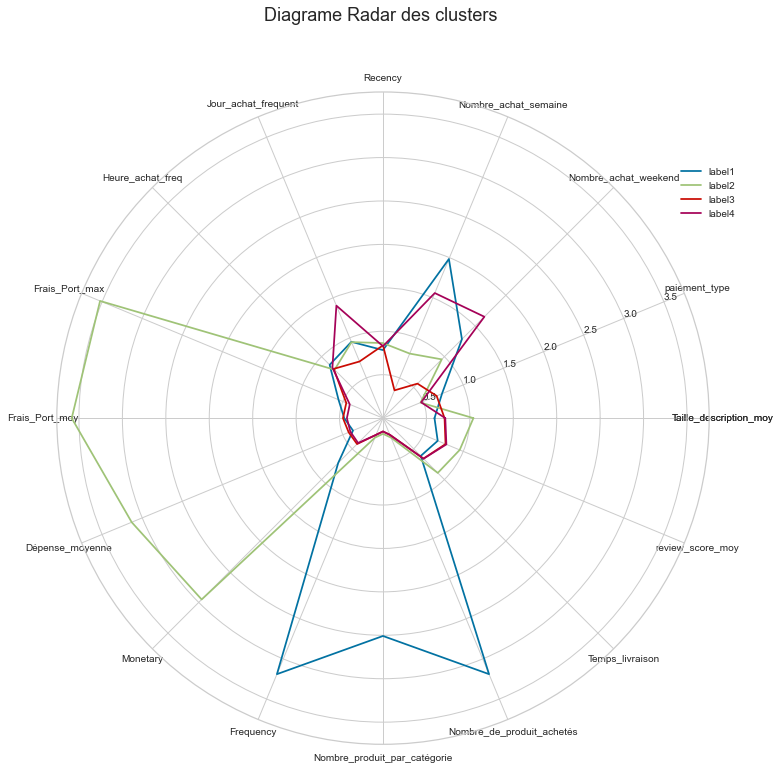

In [60]:
label_1 = data_cah_scal.iloc[0, 0:].values
label_1 = np.concatenate((label_1, [label_1[0]]))
label_2 = data_cah_scal.iloc[1, 0:].values
label_2 = np.concatenate((label_2, [label_2[0]]))
label_3 = data_cah_scal.iloc[2, 0:].values
label_3 = np.concatenate((label_3, [label_3[0]]))
label_4 = data_cah_scal.iloc[3, 0:].values
label_4 = np.concatenate((label_4, [label_4[0]]))
label_placement = np.linspace(start=0, stop=2*np.pi, num=len(label_1))
c = ['Taille_description_moy', 'paiement_type', 'Nombre_achat_weekend',
     'Nombre_achat_semaine',
     'Recency', 'Jour_achat_frequent',
     'Heure_achat_freq', 'Frais_Port_max', 'Frais_Port_moy',
     'Dépense_moyenne',
     'Monetary', 'Frequency', 'Nombre_produit_par_catégorie',
     'Nombre_de_produit_achetés', 'Temps_livraison', 'review_score_moy',
     'Taille_description_moy']
plt.figure(figsize=(12, 12))
plt.subplot(polar=True)
plt.plot(label_placement, label_1)
plt.plot(label_placement, label_2)
plt.plot(label_placement, label_3)
plt.plot(label_placement, label_4)
lines, labels = plt.thetagrids(np.degrees(label_placement), labels=c)
plt.title('Diagrame Radar des clusters ', y=1.1, fontdict={'fontsize': 18})
plt.legend(labels=['label1', 'label2', 'label3', 'label4'], loc=(0.95, 0.8))

In [61]:
data_cah_scal

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,0.592988,0.735389,1.285327,1.983119,0.783344,0.950922,0.868149,0.554058,0.446126,0.373695,0.729198,3.190175,2.507886,3.190175,0.614979,0.681847
1,1.041081,0.468599,0.956962,0.804259,0.864314,0.947206,0.788038,3.525397,3.583452,3.131376,2.952142,0.243582,0.180615,0.243582,0.891941,0.956114
2,0.708847,0.668925,0.561875,0.346156,0.837681,0.706019,0.802210,0.457427,0.460692,0.427469,0.422007,0.207702,0.153205,0.207702,0.659055,0.779589
3,0.717379,0.475439,1.650765,1.558771,0.828048,1.401682,0.823299,0.413944,0.415467,0.407007,0.404670,0.208545,0.153205,0.208545,0.660194,0.789938


- Cluster  se caractérise par : ceux qui ont achetés beaucoup de fois
- Cluster  se caractérise par : ceux qui consomme le plus en terme d'argent
- Cluster  se caractérise par : ceux qui ont plus tendance à faire des achats en début de semaine 
- Cluster  se caractérise par : ceux qui ont plus tendance à faire des achats en fin de semaine

## Modélisation

D'après les graphes, on remarque que les clusters pour les scénarios de dataset complet et les données projetés sont plus homogénes.
Donc on va opter à l'utilisation du jeu de donnée avec 4 clusters. Puis on va interpréter les résultats.

In [62]:
def Model(donnee, nbr):
    model = KMeans(n_clusters=nbr, random_state=0).fit(donnee)
    centroids = model.cluster_centers_
    labels = model.labels_
    inertia = model.inertia_
    silhouette_scores = silhouette_score(donnee, model.labels_)
    index_db_val = davies_bouldin_score(donnee, labels)
    data_plot['labels'] = model.labels_
    plt.figure(figsize=(8, 8))
    plt.scatter(x=data_plot['F1'], y=data_plot['F2'],
                c=data_plot['labels'], cmap="nipy_spectral")
    plt.title('Clustering avec K-Means pour ' + str(nbr) + ' Clusters')
    plt.legend()
    plt.show()
    return labels

<ipython-input-62-0e7170776713>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_plot['labels'] = model.labels_
No handles with labels found to put in legend.


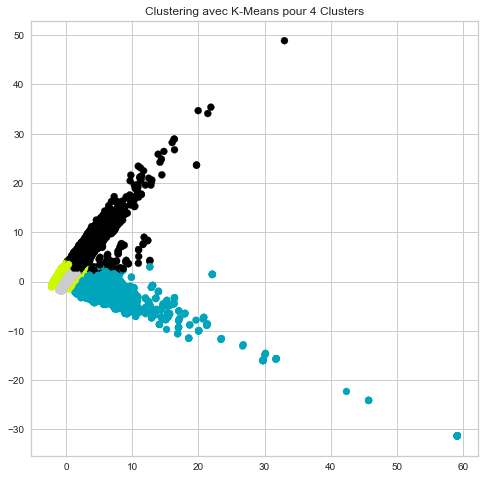

In [63]:
labels = Model(data_scaled, 4)

In [64]:
data_int = np.abs(data - data.mean()) / data.std()
data_int['labels'] = labels
data_int_s = data_int.groupby('labels').mean().reset_index()
data_int_s
data_int_s.drop(columns='labels', inplace=True)

,labels,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,0,0.992971,0.540781,0.759087,0.575762,0.843960,0.822092,0.778134,3.020780,3.044997,2.836827,2.669239,0.273010,0.184720,0.273010,0.827648,0.888005
1,1,0.603270,0.744315,1.139055,2.037912,0.803393,0.926590,0.856349,0.509296,0.421551,0.370049,0.734583,3.153381,2.597950,3.153381,0.632983,0.678173
2,2,0.704224,0.563994,1.689541,1.544051,0.829218,1.409800,0.822004,0.445610,0.445561,0.400889,0.398627,0.240899,0.150977,0.240899,0.676086,0.781659
3,3,0.708059,0.645143,0.543629,0.319081,0.835944,0.697696,0.803982,0.432635,0.433605,0.396624,0.391860,0.205063,0.150977,0.205063,0.663663,0.780527


In [65]:
data['labels'] = labels

On va calculer le nombre de de clients par cluster  

In [94]:
cluster_count = data.groupby('labels').count().reset_index()['Recency']
cluster_count

0     4167
1     5457
2    20053
3    65447
Name: Recency, dtype: int64

<BarContainer object of 4 artists>

([<matplotlib.axis.XTick at 0x269fbda3f70>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

Text(0.5, 1.0, 'La répartition des clients sur les clusters')

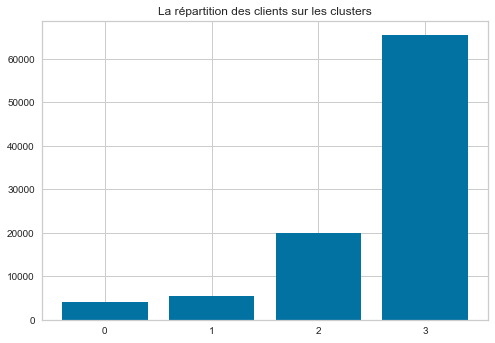

In [99]:
plt.bar(height=cluster_count,
        x=list(cluster_count.index))
plt.xticks(list(cluster_count.index))
# plt.grid()
plt.title("La répartition des clients sur les clusters")
plt.show()

In [66]:
data_inter = data.groupby('labels').mean().reset_index()
data_inter

,labels,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,0,1173.795536,0.853612,0.191265,0.838253,221.653948,2.591793,14.736741,68.686242,67.820384,766.494550,784.921425,1.029518,1.008399,1.029518,16.186465,3.940725
1,1,734.160894,0.884918,0.431556,1.812901,220.805021,2.390691,14.109034,21.667156,18.199728,134.734522,302.836075,2.244457,1.602895,2.244457,11.760491,4.212571
2,2,775.065127,0.901860,1.015659,0.000000,243.482222,5.524211,15.238817,18.418903,18.357523,131.106677,133.129672,1.015659,1.000000,1.015659,12.033711,4.139730
3,3,779.477455,0.858557,0.000000,1.000000,242.008419,1.927697,14.663392,17.873578,17.873578,128.572108,128.572108,1.000000,1.000000,1.000000,11.875594,4.152795


In [67]:
list(data_inter.columns).remove('labels')

In [68]:
label_1 = data_int_s.iloc[0, 0:].values
label_1 = np.concatenate((label_1, [label_1[0]]))
label_2 = data_int_s.iloc[1, 0:].values
label_2 = np.concatenate((label_2, [label_2[0]]))
label_3 = data_int_s.iloc[2, 0:].values
label_3 = np.concatenate((label_3, [label_3[0]]))
label_4 = data_int_s.iloc[3, 0:].values
label_4 = np.concatenate((label_4, [label_4[0]]))

In [69]:
data_inter.columns

Index(['labels', 'Taille_description_moy', 'paiement_type',
       'Nombre_achat_weekend', 'Nombre_achat_semaine', 'Recency',
       'Jour_achat_frequent', 'Heure_achat_freq', 'Frais_Port_max',
       'Frais_Port_moy', 'Dépense_moyenne', 'Monetary', 'Frequency',
       'Nombre_produit_par_catégorie', 'Nombre_de_produit_achetés',
       'Temps_livraison', 'review_score_moy'],
      dtype='object')

In [70]:
len(np.degrees(label_placement))

17

In [71]:
c = ['Taille_description_moy', 'paiement_type', 'Nombre_achat_weekend',
     'Nombre_achat_semaine', 'Recency', 'Jour_achat_frequent',
     'Heure_achat_freq', 'Frais_Port_max', 'Frais_Port_moy',
     'Dépense_moyenne', 'Monetary', 'Frequency',
     'Nombre_produit_par_catégorie',
     'Nombre_de_produit_achetés', 'Temps_livraison', 'review_score_moy',
     'Taille_description_moy']
len(c)

17

<Figure size 864x864 with 0 Axes>

<PolarAxesSubplot:>

Text(0.5, 1.1, 'Diagrame Radar des clusters ')

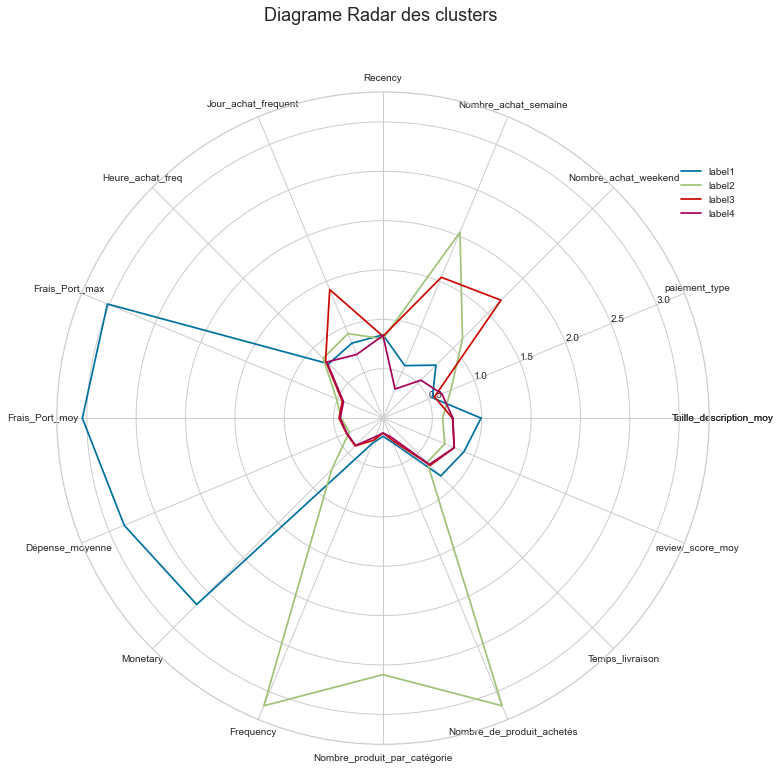

In [72]:
plt.figure(figsize=(12, 12))
plt.subplot(polar=True)
plt.plot(label_placement, label_1)
plt.plot(label_placement, label_2)
plt.plot(label_placement, label_3)
plt.plot(label_placement, label_4)
lines, labels = plt.thetagrids(np.degrees(label_placement), labels=c)
plt.title('Diagrame Radar des clusters ', y=1.1, fontdict={'fontsize': 18})
plt.legend(labels=['label1', 'label2', 'label3',  'label4'], loc=(0.95, 0.8))

In [73]:
data_int_s

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
0,0.992971,0.540781,0.759087,0.575762,0.843960,0.822092,0.778134,3.020780,3.044997,2.836827,2.669239,0.273010,0.184720,0.273010,0.827648,0.888005
1,0.603270,0.744315,1.139055,2.037912,0.803393,0.926590,0.856349,0.509296,0.421551,0.370049,0.734583,3.153381,2.597950,3.153381,0.632983,0.678173
2,0.704224,0.563994,1.689541,1.544051,0.829218,1.409800,0.822004,0.445610,0.445561,0.400889,0.398627,0.240899,0.150977,0.240899,0.676086,0.781659
3,0.708059,0.645143,0.543629,0.319081,0.835944,0.697696,0.803982,0.432635,0.433605,0.396624,0.391860,0.205063,0.150977,0.205063,0.663663,0.780527


- Cluster 1 se caractérise par : ceux qui achète le moins et souvent en début de semaine . 
- Cluster 2 se caractérise par : ceux qui consomme le plus en terme d'argent 
- Cluster 3 se caractérise par : ceux qui achète souvent pendant le weekend 
- Cluster 4 se caractérise par : ceux qui ont achetés beaucoup de fois

## Stabilité temporaire des clusters

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et voir, par exemple, à quel moment les clients changent de Cluster. Dans ce but, on doit évaluer la fréquence à laquelle la segmentation doit être mise à jour en étudiant la stabilité temporaire des clusters.

On va travailler sur une période de données(2016-2017 par exemple) selon la date des commandes. On va fixer une période (2016), on va entrainer le meilleur modèle et garder les clusters id comme labels de références, puis on va rajouter un mois( janvier 2017) et on va réentrainer notre modèle sur ce jeu de données modifié et calculer le score de ari entre les labels de références et les nouveaux labels. et on itère sur le mois prochain et de suite jusqu'à (décembre 2017).

In [74]:
data_stab = pd.read_csv(path2)

In [75]:
data_stab.head()

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy,date
0,598.0,1.0,0.0,1.0,355,2,8,13.29,13.29,72.19,72.19,1,1,1,7,5.0,2017-09-13 08:59:02
1,598.0,0.0,0.0,1.0,431,2,11,17.96,17.96,73.86,73.86,1,1,1,15,5.0,2017-06-28 11:52:20
2,598.0,1.0,0.0,1.0,107,4,10,18.33,18.33,83.23,83.23,1,1,1,17,4.0,2018-05-18 10:25:53
3,598.0,1.0,0.0,1.0,397,1,18,16.17,16.17,75.07,75.07,1,1,1,8,5.0,2017-08-01 18:38:42
4,598.0,1.0,0.0,1.0,388,3,21,13.29,13.29,72.19,72.19,1,1,1,13,5.0,2017-08-10 21:48:40


In [76]:
data_stab.date = pd.to_datetime(data_stab.date)
data_stab['year'] = data_stab.date.dt.year

In [77]:
data_stab['month'] = data_stab.date.dt.month

In [78]:
data_stab.head()

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy,date,year,month
0,598.0,1.0,0.0,1.0,355,2,8,13.29,13.29,72.19,72.19,1,1,1,7,5.0,2017-09-13 08:59:02,2017,9
1,598.0,0.0,0.0,1.0,431,2,11,17.96,17.96,73.86,73.86,1,1,1,15,5.0,2017-06-28 11:52:20,2017,6
2,598.0,1.0,0.0,1.0,107,4,10,18.33,18.33,83.23,83.23,1,1,1,17,4.0,2018-05-18 10:25:53,2018,5
3,598.0,1.0,0.0,1.0,397,1,18,16.17,16.17,75.07,75.07,1,1,1,8,5.0,2017-08-01 18:38:42,2017,8
4,598.0,1.0,0.0,1.0,388,3,21,13.29,13.29,72.19,72.19,1,1,1,13,5.0,2017-08-10 21:48:40,2017,8


In [79]:
data_stab.year.unique()

array([2017, 2018, 2016], dtype=int64)

In [80]:
data_stab = data_stab[data_stab['year'] != 2018]

In [81]:
data_stab.year.unique()

array([2017, 2016], dtype=int64)

In [82]:
data_init = data_stab[data_stab['year'] == 2016]

In [83]:
data_stab_test = data_stab[(data_stab['year'] == 2017) &
                           (data_stab['month'] == 1)]
data_stab_test.month.unique()
data_stab_test.year.unique()
data_stab_test

array([1], dtype=int64)

array([2017], dtype=int64)

,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy,date,year,month
296,120.0,0.0,0.0,1.0,591,3,20,14.52,14.52,46.02,46.02,1,1,1,10,3.0,2017-01-19 20:45:08,2017,1
297,120.0,0.0,1.0,0.0,589,5,14,14.52,14.52,46.02,46.02,1,1,1,16,4.0,2017-01-21 14:22:49,2017,1
553,1001.0,0.0,0.0,1.0,579,1,16,11.74,11.74,48.59,48.59,1,1,1,9,3.0,2017-01-31 16:59:03,2017,1
656,1487.0,1.0,0.0,1.0,583,4,13,18.00,18.00,107.57,107.57,1,1,1,15,5.0,2017-01-27 13:43:36,2017,1
657,1487.0,0.0,0.0,1.0,584,3,16,15.39,15.39,104.96,104.96,1,1,1,13,5.0,2017-01-26 16:48:24,2017,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94552,221.0,1.0,0.0,1.0,585,2,16,26.71,26.71,90.61,90.61,1,1,1,70,1.0,2017-01-25 16:38:10,2017,1
94828,369.0,1.0,0.0,1.0,580,0,21,1.20,1.20,783.00,783.00,1,1,1,14,5.0,2017-01-30 21:44:49,2017,1
94852,843.0,0.0,0.0,1.0,583,4,22,18.00,18.00,107.90,107.90,1,1,1,5,5.0,2017-01-27 22:07:02,2017,1
94886,240.0,0.0,0.0,1.0,584,3,23,20.74,20.74,239.48,239.48,1,1,1,68,1.0,2017-01-26 23:20:31,2017,1


In [84]:
def model_stab(data):
    kmeans_init = Pipeline([("prep", sklearn.preprocessing.StandardScaler()),
                            ("kmeans", KMeans(4, random_state=0))])
    kmeans_init.fit(data)
    init_labels = kmeans_init.named_steps['kmeans'].labels_
    length = len(init_labels)
    return init_labels, length, kmeans_init

In [85]:
def add_data(data1, data2, month):
    s2 = data2[(data2['year'] == 2017) & (data2['month'] == month)]
    s2.drop(columns=['date', 'month', 'year'], inplace=True)
    data1 = pd.concat([data1, s2])
    return data1

In [86]:
data_init.drop(columns=['date', 'month', 'year'], inplace=True)
data_init.head()

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Taille_description_moy,paiement_type,Nombre_achat_weekend,Nombre_achat_semaine,Recency,Jour_achat_frequent,Heure_achat_freq,Frais_Port_max,Frais_Port_moy,Dépense_moyenne,Monetary,Frequency,Nombre_produit_par_catégorie,Nombre_de_produit_achetés,Temps_livraison,review_score_moy
302,100.000000,1.0,0.0,1.0,698,1,14,17.61,17.610000,111.510000,111.51,1,1,1,7,3.000000
6041,651.666667,1.0,0.0,3.0,66,0,8,15.56,10.756667,29.053333,87.16,3,2,3,23,4.666667
6284,204.500000,1.0,0.0,2.0,401,4,9,17.13,15.580000,310.030000,620.06,2,2,2,27,5.000000
12402,426.000000,0.0,0.0,1.0,698,1,14,22.34,22.340000,62.330000,62.33,1,1,1,22,5.000000
12412,686.000000,1.0,0.0,2.0,692,0,15,14.11,12.955000,90.410000,180.82,2,2,2,16,5.000000


In [87]:
import collections
ari_score = []
init_labels, length, model11 = model_stab(data_init)
length_init = length
value = []
lab=[]
for p in np.arange(0, 12):
    # Create dataset for period
    data_init = add_data(data_init, data_stab, month=p+1)
    labels, length, model1 = model_stab(data_init)
    model.predict(data_init)
    # Filter on initial customer client
    # Calculate ARI score
    dict_label = collections.Counter(labels)
    for i in range(4):
        lab.append(i)
        value.append(dict_label[i])
    ari_p = adjusted_rand_score(init_labels, labels[:length_init])
    ari_score.append([p+1, ari_p])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 5])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 1])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 1, 1])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 5])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 5])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 1, 5, 1])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 1])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 5])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 1, 5, 1])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 1, 5])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 5])

C:\Users\Utilisateur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


array([5, 1, 5, ..., 5, 5, 5])

6:4: E225 missing whitespace around operator


L'indice de Rand calcule une mesure de similarité entre deux regroupements en considérant toutes les paires d'échantillons et en comptant les paires qui sont attribuées dans des regroupements identiques ou différents dans les regroupements prédit et les regroupements principales. 

<AxesSubplot:xlabel='periode', ylabel='ARI'>

Text(0.5, 0, 'Période (mois)')

Text(0, 0.5, 'Score ARI')

Text(0.5, 1.0, 'Stabilité temporelle de la segmentation par K-Means')

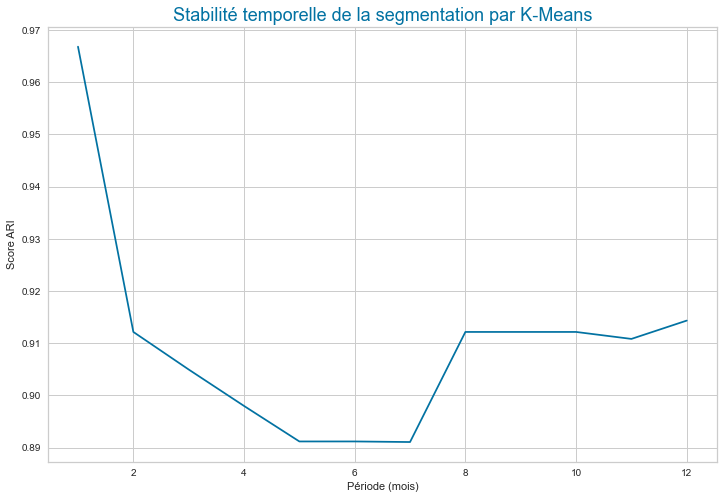

In [88]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])
# plot ARI Score
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus sur les itérations par période de 1 mois, le premier mois qui représente une forte inflexion est le nombre de mois au bout duquel faut lancer la maintenance et relancer le process de l'étude de modélisation et du contrat de maintenance .